In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [3]:
%cd /content
!unzip /content/drive/'My Drive'/fingerprint/dataset.zip
%cd /content

/content
Archive:  /content/drive/My Drive/fingerprint/dataset.zip
   creating: dataset/
  inflating: dataset/x_real.npy      
  inflating: dataset/x_zoom.npy      
  inflating: dataset/x_noise.npy     
  inflating: dataset/x_h_shifted.npy  
  inflating: dataset/x_v_shifted.npy  
  inflating: dataset/y_real.npy      
/content


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


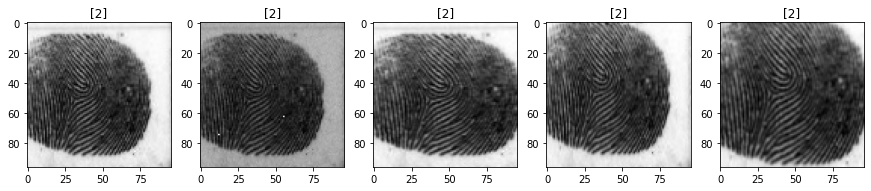

In [4]:
x_real = np.load('/content/dataset/x_real.npy')
x_h_shifted = np.load('/content/dataset/x_h_shifted.npy')
x_v_shifted = np.load('/content/dataset/x_v_shifted.npy')
x_zoom = np.load('/content/dataset/x_zoom.npy')
x_noise = np.load('/content/dataset/x_noise.npy')

y_real = np.load('/content/dataset/y_real.npy')

index =2
plt.figure(figsize=(15, 10))
plt.subplot(1, 5, 1)
plt.title(y_real[index])
plt.imshow(x_real[index].squeeze(), cmap='gray')
plt.subplot(1, 5, 2)
plt.title(y_real[index])
plt.imshow(x_noise[index].squeeze(), cmap='gray')
plt.subplot(1, 5, 3)
plt.title(y_real[index])
plt.imshow(x_h_shifted[index].squeeze(), cmap='gray')
plt.subplot(1, 5, 4)
plt.title(y_real[index])
plt.imshow(x_v_shifted[index].squeeze(), cmap='gray')
plt.subplot(1, 5, 5)
plt.title(y_real[index])
plt.imshow(x_zoom[index].squeeze(), cmap='gray')

# Train Test Split

In [5]:
x_data = np.concatenate([x_h_shifted, x_v_shifted, x_noise, x_zoom], axis=0)
label_data = np.concatenate([y_real, y_real, y_real, y_real], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(83152, 96, 96, 1) (83152, 1)
(74836, 96, 96, 1) (74836, 1)
(8316, 96, 96, 1) (8316, 1)


# Preview Augmentation

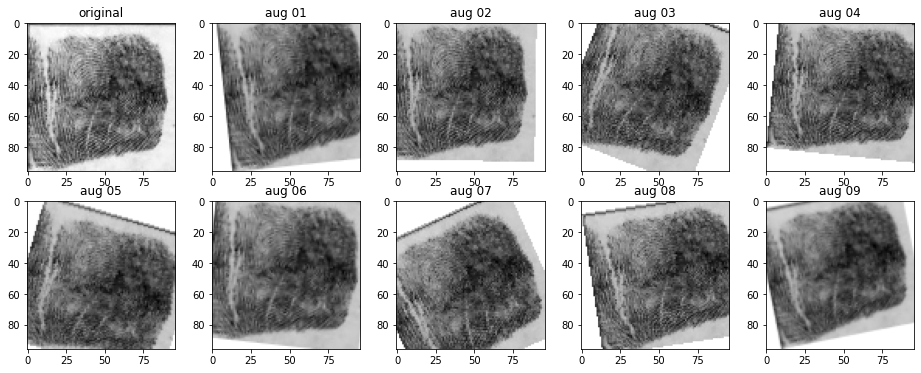

In [6]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [7]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key)

    label_real_dict[key] = i


print(label_real_dict)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97, '98': 98, '99': 99, '100': 100, '101': 

# Data Generator

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [11]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# Create Model

In [ ]:
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

# share weights both inputs
inputs = layers.Input(shape=(96, 96, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 24, 24, 32)   9568        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 24, 24, 32)   0           model[0][0]                

# Train

In [ ]:
history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
2338/2338 [==============================] - 113s 45ms/step - loss: 0.2147 - acc: 0.9092 - val_loss: 0.1353 - val_acc: 0.9533
Epoch 2/15
2338/2338 [==============================] - 106s 46ms/step - loss: 0.0982 - acc: 0.9638 - val_loss: 0.0540 - val_acc: 0.9815
Epoch 3/15
2338/2338 [==============================] - 107s 46ms/step - loss: 0.0842 - acc: 0.9700 - val_loss: 0.0448 - val_acc: 0.9849
Epoch 4/15
2338/2338 [==============================] - 104s 44ms/step - loss: 0.0707 - acc: 0.9745 - val_loss: 0.0314 - val_acc: 0.9882
Epoch 5/15
2338/2338 [==============================] - 104s 44ms/step - loss: 0.0620 - acc: 0.9772 - val_loss: 0.0362 - val_acc: 0.9861
Epoch 6/15
2338/2338 [==============================] - 106s 45ms/step - loss: 0.0554 - acc: 0.9801 - val_loss: 0.0266 - val_acc: 0.9902
Epoch 7/15
2338/2338 [==============================] - 105s 45ms/step - loss: 0.0520 - acc: 0.9814 - val_loss: 0.0283 - val_acc: 0.9891
Epoch 8/15
2338/2338 [===================

In [ ]:
model.save("/content/fingerprint.h5")

# Evaluation

In [12]:
model = keras.models.load_model('/content/fingerprint.h5')

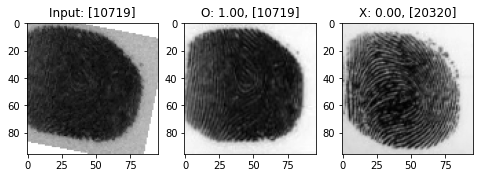

In [17]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key)

rx = x_real[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')